# On-Balance Volume (OBV)

This is the momentum strategy - the intuition here is market sentiment. 
<br>
This strategy is looking at the gap between institutional investors and retail investors. 
<br>
As retail investors are selling, the institutional investors would be buying which drives up volume but the prices stays the same.
<br>
At the same time, when retail investors are driving up the price, the institutional investors are selling, and we see a fall in on-balance volume (OBV).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns; sns.set_style('darkgrid')

import pandas_datareader as pdr

In [2]:
ticker = input('Please input the ticker you want to look at: ').upper()
# upper() function to capitalise

start = '2017-01-01'
end = '2021-01-01'

data = pdr.DataReader(ticker, 'yahoo', start, end)['Adj Close']
volume = pdr.DataReader(ticker, 'yahoo', start, end)['Volume']

Please input the ticker you want to look at:  F


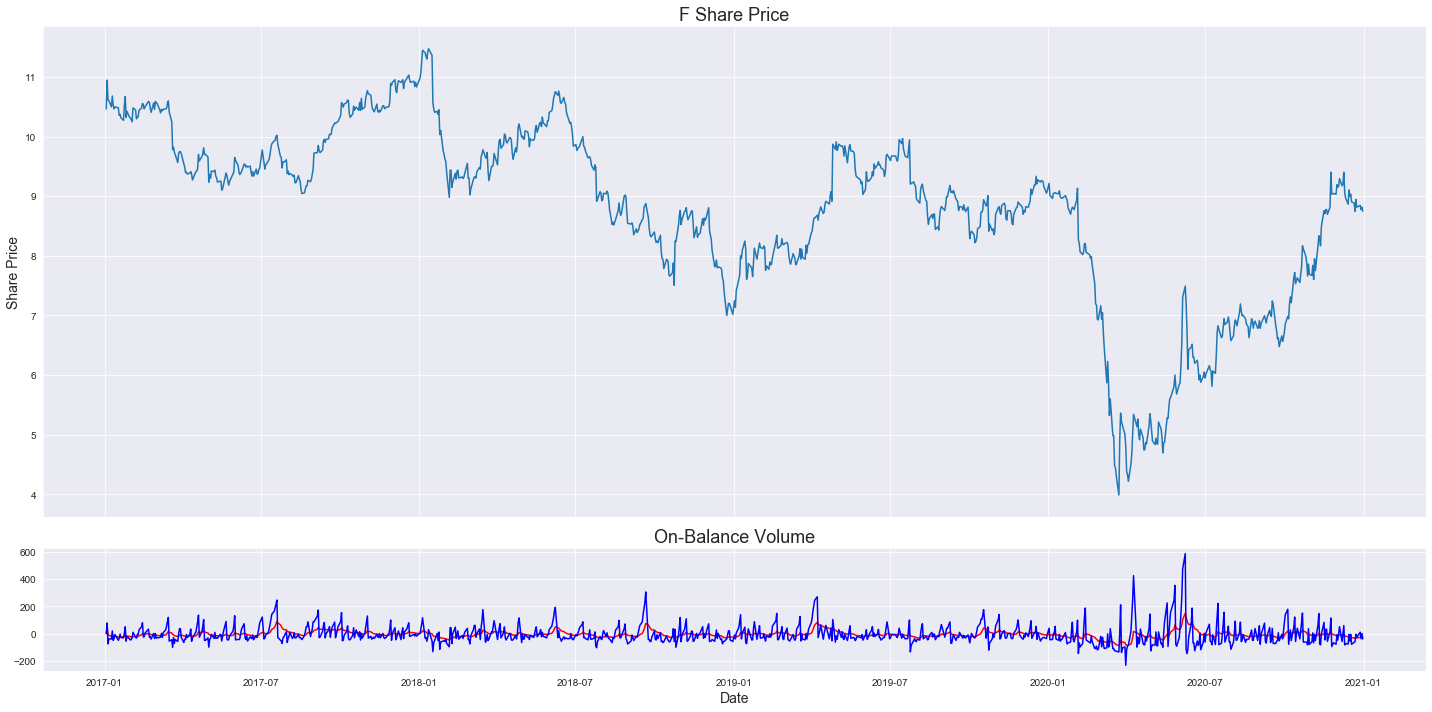

In [3]:
obv = []
obv.append(0)
# So that we start at point 0.

for i in range(1, len(data)):
    if data[i] > data[i-1]:
        obv.append(obv[-1] + volume[i])
    elif data[i] < data[i-1]:
        obv.append([-1] - volume[i])
    else:
        obv.append(obv[-1])  
        
obv_df = pd.DataFrame()

obv_df['Date'] = data.index
# We need the data index and the OBV index to match so we add in the data index into the OBV dataframe

obv_df = obv_df.set_index(obv_df['Date'])
# We then set that column as the index using the set_index() function

obv_df = obv_df.drop('Date', axis=1)
# We then drop the Date column as we now have that column as the index.

obv_df['OBV'] = obv
obv_df['OBV EMA'] = obv_df['OBV'].ewm(span=20).mean()

fig, ax = plt.subplots(2, figsize=(20,10), sharex='col', gridspec_kw={'height_ratios': [2, 0.5]})
# The sharex=cols parameter allows the two subplots to have the same x-axis
# the gridspec_kw={'height_ratios': [2, 0.5]} is a dictionary and allows us to change the sizes
# of the two graphs with respect to each other.

fig.subplots_adjust(hspace=0, wspace=0)
# The subplots_adjust function() allows us to adjust the height space and width space between the
# 2 subplots.

ax[0].plot(data)
ax[0].set_title(f'{ticker} Share Price', fontsize=18)
ax[0].set_ylabel('Share Price', fontsize=14)
# Since we are using axes (ax) and not plot (plt.plot()) the functions changes ever so slightly too
# Instead of saying title() we say set_title().
# Instead of saying ylabel() we say set_set_ylabel().

ax[1].plot(obv_df['OBV EMA']/1000000, color='red', alpha=1)
# We make a minor adjustment to the volume to make the graph prettier - the result should not matter
# too much as it's the shape we're interested in and if all the data is divided evenly, it will make
# no difference to the shape of the data.

ax[1].plot(obv_df['OBV']/1000000, color='blue', alpha=1)

ax[1].set_title('On-Balance Volume', fontsize=18)
ax[1].set_xlabel('Date', fontsize=14)
# Instead of saying title() we say set_title().
# Instead of saying xlabel() we say set_xlabel().

plt.tight_layout()
plt.show();

The idea for trading OBV is that when the OBC goes above the OBV Exponentially Weighted Moving Average we buy into the stock, and if it goes below it we sell. 
<br>
Let's plot the actual trading indicators to visualise this a bit clearer:

In [4]:
def obv_buysell(data, obv_data, obv_ewm_data):
# We start off by creating a buy/sell function for the OBV strategy:
    
    signal_buy_price = []
    signal_sell_price = []
    # Now we create two empty lists to store the buy price and sell prices in.
    
    flag = -1
    # This is created for us to use as a signal of what our current position is in the asset.
        # flag = 1 would mean we open a position in the asset.
        # flag = 0 would mean we close the position in the asset.
        # flag = -1 would mean we do not have a position in the asset.
    # By default, we state we do not have a position hence flag = -1
    
    for i in range(0, len(data)):
    # The range() function gives us back a range of values.
    # The first and second parameters are the start and end.
    # We have specified for the range of data to start at 0 and end at how many ever data points we have.
        # The number of data points in our data is given by the length of the data; the length function len().
        
        if obv_data[i] > obv_ewm_data[i] and flag != 1:
        # The above code says:
        # If the OBV data at the ith data point is greater than the OBV EWM data at the ith data point AND
        # our flag DOES NOT equal 1 (we do not have an open position in the asset) then...
            
            signal_buy_price.append(data[i])
            # If the above statement holds true then we shall add a the price data of the asset at the ith
            # data point, since we are buying into the asset and we want the price of the asset at the time
            # we buy into.
            
            signal_sell_price.append(np.nan)
            # Since we are buying into the data, we do not need any values in the sell signal list.
            # However, we need to make sure that the buy and sell lists are of the same length so they can
            # be comparable, and also plotted.
            
            flag = 1
            # We add this statement to let the loop know that we now have a position open in this asset.
            
        elif obv_data[i] < obv_ewm_data[i] and flag != 0:
        # The above code says:
        # Else if the OBV data at the ith data point is less than the OBV EWM data at the ith data point AND
        # our flag DOES NOT equal to 0 (either we already have a position open in the asset flag=1; or we do
        # not have a position open in the asset flag=-1 and we wish to short the asset).
            
            signal_buy_price.append(np.nan)
            # Since we are looking to either short or close our buy position, we would not be buying anything
            # at this point in time, so we would add in a nan (not a number) value to the list.
            
            signal_sell_price.append(data[i])
            # Instead we would be adding the ith data point to the sell price.
            
            flag = 0
            # Now the loop knows that we have closed the position.
            
        else:
        # In the other possibilitly that the OBV data is greater than the OBV EWM data but we already have a 
        # position open (flag=1), or the OBV data is less than the OBV EWM data but we have already closed a
        # position or shorted, or when the OBV and the OBV EWM data are exactly equal to each other whatever 
        # our position may be, then...
            
            signal_buy_price.append(np.nan)
            signal_sell_price.append(np.nan)
            # We do nothing.

    return(signal_buy_price, signal_sell_price)
    # We return the signal points of when to buy and sell the asset.
    
buy, sell = obv_buysell(data, obv_df['OBV'], obv_df['OBV EMA'])
obv_df['Buy Signal'] = buy
obv_df['Sell Signal'] = sell
# We add the data into our obv dataframe

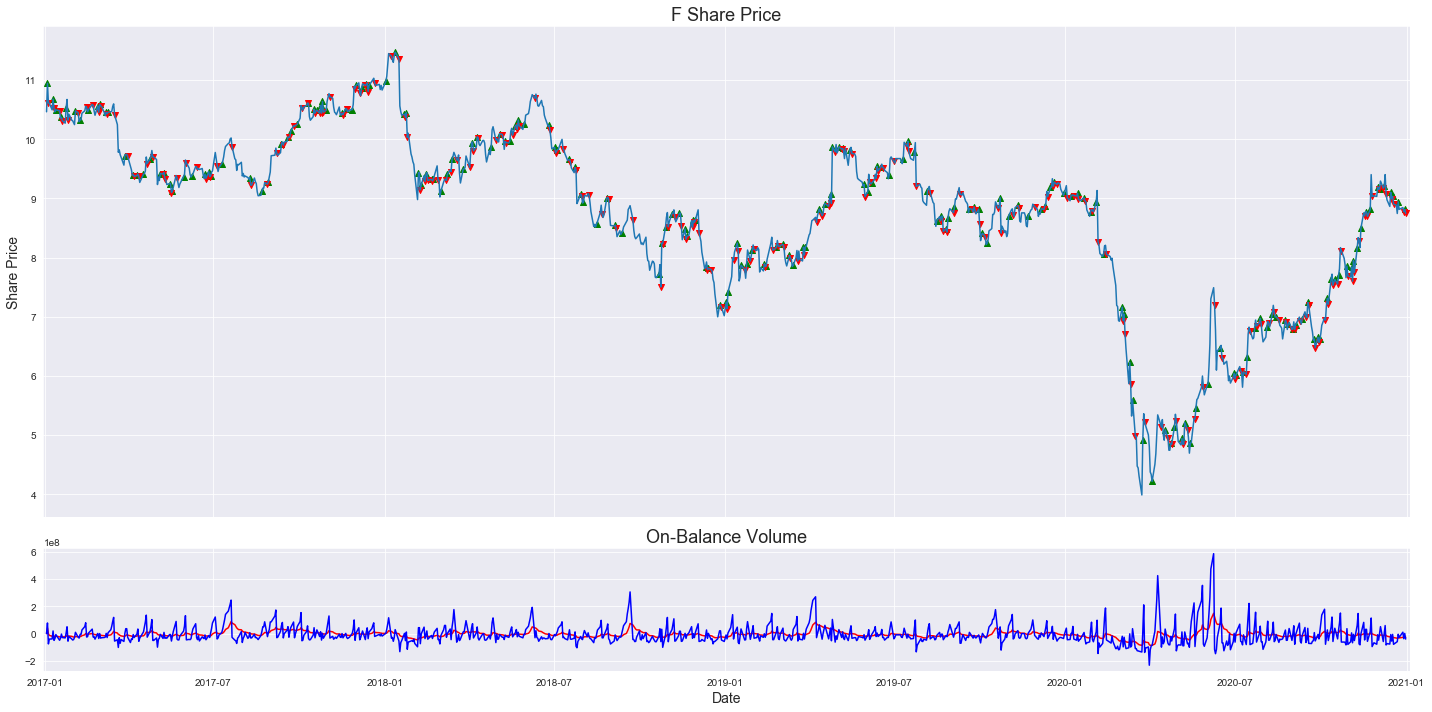

In [7]:
# OBV Summary

## OBV Buy/Sell Function
def obv_buysell(data, obv_data, obv_ewm_data):
    signal_buy_price = []
    signal_sell_price = []
    flag = -1
    for i in range(0, len(data)):
        if obv_data[i] > obv_ewm_data[i] and flag != 1:
            signal_buy_price.append(data[i])
            signal_sell_price.append(np.nan)
            flag = 1
        elif obv_data[i] < obv_ewm_data[i] and flag != 0:
            signal_buy_price.append(np.nan)
            signal_sell_price.append(data[i])
            flag = 0
        else:
            signal_buy_price.append(np.nan)
            signal_sell_price.append(np.nan)
    return(signal_buy_price, signal_sell_price)

obv = []
obv.append(0)
for i in range(1, len(data)):
    if data[i] > data[i-1]:
        obv.append(obv[-1] + volume[i])
    elif data[i] < data[i-1]:
        obv.append([-1] - volume[i])
    else:
        obv.append(obv[-1])  
        
obv_df = pd.DataFrame()

obv_df['Date'] = data.index
obv_df = obv_df.set_index(obv_df['Date'])
obv_df = obv_df.drop('Date', axis=1)
obv_df['OBV'] = obv
obv_df['OBV EMA'] = obv_df['OBV'].ewm(span=20).mean()

buy, sell = obv_buysell(data, obv_df['OBV'], obv_df['OBV EMA'])
obv_df['Buy Signal'] = buy
obv_df['Sell Signal'] = sell

## OBV Plot
fig, ax = plt.subplots(2, figsize=(20,10), sharex='col', gridspec_kw={'height_ratios': [2, 0.5]})
fig.subplots_adjust(hspace=0, wspace=0)
ax[0].plot(data)
ax[0].set_title(f'{ticker} Share Price', fontsize=18)
ax[0].set_ylabel('Share Price', fontsize=14)

ax[0].scatter(data.index, obv_df['Buy Signal'], label='Buy Price', marker='^', color='green')
ax[0].scatter(data.index, obv_df['Sell Signal'], label='Sell Price', marker='v', color='red')
# We add our code into our plot

ax[1].plot(obv_df['OBV EMA'], color='red', alpha=1)
ax[1].plot(obv_df['OBV'], color='blue', alpha=1)
ax[1].set_title('On-Balance Volume', fontsize=18)
ax[1].set_xlabel('Date', fontsize=14)

plt.margins(x=0)
# We add this code in to get rid of the excess white space 

plt.tight_layout()
plt.show();

# We use plt when we want a change to apply to the whole plot.
# We use ax[i] when we want a change to specifically apply to that single ith subplot and nothing else.

In [ ]:
# We can tidy this up now and put it into a function:

def obv(data):
    
    ## OBV Buy/Sell Function
    def obv_buysell(data, obv_data, obv_ewm_data):
        signal_buy_price = []
        signal_sell_price = []
        flag = -1
        for i in range(0, len(data)):
            if obv_data[i] > obv_ewm_data[i] and flag != 1:
                signal_buy_price.append(data[i])
                signal_sell_price.append(np.nan)
                flag = 1
            elif obv_data[i] < obv_ewm_data[i] and flag != 0:
                signal_buy_price.append(np.nan)
                signal_sell_price.append(data[i])
                flag = 0
            else:
                signal_buy_price.append(np.nan)
                signal_sell_price.append(np.nan)
        return(signal_buy_price, signal_sell_price)

    obvl = []
    obvl.append(0)
    for i in range(1, len(data)):
        if data[i] > data[i-1]:
            obvl.append(obvl[-1] + volume[i])
        elif data[i] < data[i-1]:
            obvl.append([-1] - volume[i])
        else:
            obvl.append(obvl[-1])  
    # We have replaced obv with obvl (for obv list) as obv would conflict with the name of the function - obv.
    
    obv_df = pd.DataFrame()

    obv_df['Date'] = data.index
    obv_df = obv_df.set_index(obv_df['Date'])
    obv_df = obv_df.drop('Date', axis=1)
    obv_df['OBV'] = obvl
    obv_df['OBV EMA'] = obv_df['OBV'].ewm(span=20).mean()

    buy, sell = obv_buysell(data, obv_df['OBV'], obv_df['OBV EMA'])
    obv_df['Buy Signal'] = buy
    obv_df['Sell Signal'] = sell
    
    def obv_plot():    
        ## OBV Plot
        fig, ax = plt.subplots(2, figsize=(20,10), sharex='col', gridspec_kw={'height_ratios': [2, 0.5]})
        fig.subplots_adjust(hspace=0, wspace=0)
        ax[0].plot(data)
        ax[0].set_title(f'{ticker} Share Price', fontsize=18)
        ax[0].set_ylabel('Share Price', fontsize=14)

        ax[0].scatter(obv_df.index, obv_df['Buy Signal'], label='Buy Price', marker='^', color='green')
        ax[0].scatter(obv_df.index, obv_df['Sell Signal'], label='Sell Price', marker='v', color='red')
        # We add our code into our plot

        ax[1].plot(obv_df['OBV EMA']/1000000, color='red', alpha=1)
        ax[1].plot(obv_df['OBV']/1000000, color='blue', alpha=1)
        ax[1].set_title('On-Balance Volume', fontsize=18)
        ax[1].set_xlabel('Date', fontsize=14)

        plt.margins(x=0)
        # We add this code in to get rid of the excess white space 

        plt.tight_layout()
        plt.show();
    
    return obv_df

In [47]:
# obv(data).obv_plot();
# We can try running the line of code above.

Notice here how our plot doesn't work if we try to immediately call it from within the function without packaging it first.
<br>
This is when we need to use the class function.

The class function is something a method known as Object Oriented Programming - the method that literally everyone use and all Python codes are typically written in classes so they can be later called.
<br>
We will dive into this at the end of this section.